<a href="https://colab.research.google.com/github/alexndremelyanov/_/blob/main/L6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from prettytable import PrettyTable

In [179]:
def deserialize(filename):

    data = pd.read_csv(filename)

    categorical_features = [
        'Credit History', 'Purpose', 'Personal Status and Gender',
        'Job Category', 'Telephone', 'Foreign Worker Status',
        'Other Debtors / Guarantors', 'Other Credits', 'Home Ownership',
    ]

    numeric_features = ['Loan Amount']

    transformers = [
        ('categorical', OneHotEncoder(), categorical_features),
        ('numeric', StandardScaler(), numeric_features)
    ]

    preprocessor = ColumnTransformer(transformers)

    X = data.drop(['Customer ID', 'Checking Account Status',
                   'Loan Status','Present Employment Time (Years)',
                   'Savings Account Balance', 'Property'],
                   axis=1)

    X_transformed = preprocessor.fit_transform(X)

    Y = data['Loan Status'].map({'fully paid': 1, 'charged off': 0})

    return X_transformed.toarray(), Y.to_numpy()

In [180]:
def add_intercept(a):
    a_ext = np.zeros((a.shape[0], a.shape[1] + 1))
    a_ext[:, 0] = 1
    a_ext[:, 1:] = a
    return a_ext

In [181]:
class SVMClassification(object):
    def __init__(self, learning_rate=0.01, lam=0.1, max_iter=200):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.lam = lam
        self.w = None
        self.history_w = []
        self.train_errors = None
        self.test_errors = None
        self.train_loss = None
        self.test_loss = None

    def predict(self, X: np.array) -> np.array:
        x_ext = add_intercept(X)
        return np.sign(np.dot(self.w, x_ext.T))

    def hinge_loss(self, x, y):
        return max(0, 1 - y * (np.dot(x, self.w)))

    def loss(self, x, y):
        losses = [self.hinge_loss(xi, yi) for xi, yi in zip(x, y)]
        return np.mean(losses) + self.lam * np.dot(self.w, self.w)

    def fit(self, X_train, Y_train, X_test, Y_test, verbose=False):
        X_train = add_intercept(X_train)
        X_test = add_intercept(X_test)
        self.w = np.random.normal(loc=0, scale=0.05, size=X_train.shape[1])
        self.history_w.append(self.w)
        train_loss_epoch = []
        test_loss_epoch = []

        for epoch in range(self.max_iter):
            for i, x in enumerate(X_train):
                margin = Y_train[i] * np.dot(self.w, X_train[i])
                if margin >= 1:
                    gradient = 2 * self.lam * self.w
                else:
                    gradient = -Y_train[i] * X_train[i] + 2 * self.lam * self.w
                self.w -= (self.learning_rate / len(X_train)) * gradient

            train_hinge_loss = self.loss(X_train, Y_train)
            test_hinge_loss = self.loss(X_test, Y_test)
            train_loss_epoch.append(train_hinge_loss)
            test_loss_epoch.append(test_hinge_loss)
            if verbose:
                print(f'Epoch {epoch + 1}: Train Mean Hinge Loss: {train_hinge_loss}, Test Mean Hinge Loss: {test_hinge_loss}')


        self.train_loss = np.array(train_loss_epoch)
        self.test_loss = np.array(test_loss_epoch)
        self.history_w = np.array(self.history_w)


In [182]:
X, Y = deserialize('./German Credit Cards UCI.csv')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=103)

svm_model = SVMClassification(learning_rate=0.001, lam=0.0005, max_iter=500)
svm_model.fit(X_train, Y_train, X_test, Y_test, verbose=False)

In [183]:
table = PrettyTable()

table.field_names = ['EPOCH', "TRAIN_LOSS", "TEST_LOSS"]

data = zip(range(1, len(svm_model.train_loss) + 1), svm_model.train_loss, svm_model.test_loss)

for row in data:
    table.add_row(row)

print(table)

+-------+---------------------+---------------------+
| EPOCH |      TRAIN_LOSS     |      TEST_LOSS      |
+-------+---------------------+---------------------+
|   1   |  0.9968408284191252 |  0.9983774793081638 |
|   2   |  0.9938509894310886 |  0.9954171520572678 |
|   3   |  0.9908611564227235 |  0.9924568307565318 |
|   4   |  0.9878713293940184 |  0.989496515405944  |
|   5   |  0.9848815083449615 |  0.9865362060054927 |
|   6   |  0.9818916932755407 |  0.9835759025551661 |
|   7   |  0.9789018841857443 |  0.9806156050549518 |
|   8   |  0.9759120810755597 |  0.9776553135048383 |
|   9   |  0.9729222839449757 |  0.9746950279048134 |
|   10  |   0.96993249279398  |  0.9717347482548655 |
|   11  |  0.9669427076225602 |  0.968774474554982  |
|   12  |  0.963952928430705  |  0.9658142068051517 |
|   13  |  0.960963155218402  |  0.9628539450053621 |
|   14  |  0.9579733879856397 |  0.9598936891556017 |
|   15  |  0.9549836267324059 |  0.9569334392558587 |
|   16  |  0.951993871458688

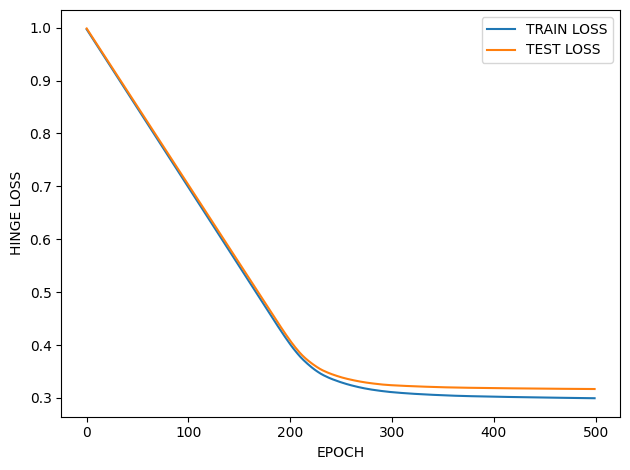

In [184]:
plt.plot(range(0, len(svm_model.train_loss)), svm_model.train_loss, label='TRAIN LOSS')
plt.plot(range(0, len(svm_model.test_loss)), svm_model.test_loss, label='TEST LOSS')
plt.xlabel("EPOCH")
plt.ylabel("HINGE LOSS")
plt.legend()
plt.tight_layout()
plt.show()